# 通过OCR实现验证码识别

作者: [GT_老张](https://github.com/GT-ZhangAcer)  
时间: 2020.11

本篇将介绍如何通过飞桨实现简单的CRNN+CTC自定义数据集OCR识别模型，数据集采用[CaptchaDataset](https://github.com/GT-ZhangAcer/CaptchaDataset)中OCR部分的9453张图像，其中前8453张图像在本案例中作为训练集，后1000张则作为测试集。  
在更复杂的场景中推荐使用[PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR)产出工业级模型，模型轻量且精度大幅提升。  
同样也可以在[PaddleHub](https://www.paddlepaddle.org.cn/hubdetail?name=chinese_ocr_db_crnn_mobile&en_category=TextRecognition)中快速使用PaddleOCR。



**数据展示**
<p align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/865dd55861e24cfaa601d9f87655776c1458d099b487449f946da9b3138fc700" width="400"><br/>
</p>

## 自定义数据集读取器

常见的开发任务中，我们并不一定会拿到标准的数据格式，好在我们可以通过自定义Reader的形式来随心所欲读取自己想要数据。 

设计合理的Reader往往可以带来更好的性能，我们可以将读取标签文件列表、制作图像文件列表等必要操作在`__init__`特殊方法中实现。这样就可以在实例化`Reader`时装入内存，避免使用时频繁读取导致增加额外开销。同样我们可以在`__getitem__`特殊方法中实现如图像增强、归一化等个性操作，完成数据读取后即可释放该部分内存。    
需要我们注意的是，如果不能保证自己数据十分纯净，可以通过`try`和`expect`来捕获异常并指出该数据的位置。当然也可以制定一个策略，使其在发生数据读取异常后依旧可以正常进行训练。  

In [1]:
# 解压数据集
!unzip OCR_Dataset.zip -d data/

Archive:  OCR_Dataset.zip
   creating: data/OCR_Dataset/
  inflating: data/OCR_Dataset/63.jpg  
  inflating: data/OCR_Dataset/6400.jpg  
  inflating: data/OCR_Dataset/823.jpg  
  inflating: data/OCR_Dataset/4217.jpg  
  inflating: data/OCR_Dataset/3578.jpg  
  inflating: data/OCR_Dataset/2666.jpg  
  inflating: data/OCR_Dataset/5109.jpg  
  inflating: data/OCR_Dataset/2100.jpg  
  inflating: data/OCR_Dataset/4571.jpg  
  inflating: data/OCR_Dataset/7078.jpg  
  inflating: data/OCR_Dataset/1409.jpg  
  inflating: data/OCR_Dataset/9055.jpg  
  inflating: data/OCR_Dataset/6366.jpg  
  inflating: data/OCR_Dataset/189.jpg  
  inflating: data/OCR_Dataset/9041.jpg  
  inflating: data/OCR_Dataset/6372.jpg  
  inflating: data/OCR_Dataset/2114.jpg  
  inflating: data/OCR_Dataset/4565.jpg  
  inflating: data/OCR_Dataset/4203.jpg  
  inflating: data/OCR_Dataset/2672.jpg  
  inflating: data/OCR_Dataset/6414.jpg  
  inflating: data/OCR_Dataset/77.jpg  
  inflating: data/OCR_Dataset/8439.jpg  
  infl

  inflating: data/OCR_Dataset/8570.jpg  
  inflating: data/OCR_Dataset/7643.jpg  
  inflating: data/OCR_Dataset/6549.jpg  
  inflating: data/OCR_Dataset/1226.jpg  
  inflating: data/OCR_Dataset/8564.jpg  
  inflating: data/OCR_Dataset/7657.jpg  
  inflating: data/OCR_Dataset/3431.jpg  
  inflating: data/OCR_Dataset/5040.jpg  
  inflating: data/OCR_Dataset/5726.jpg  
  inflating: data/OCR_Dataset/2049.jpg  
  inflating: data/OCR_Dataset/3357.jpg  
  inflating: data/OCR_Dataset/4438.jpg  
  inflating: data/OCR_Dataset/8202.jpg  
  inflating: data/OCR_Dataset/7131.jpg  
  inflating: data/OCR_Dataset/1540.jpg  
  inflating: data/OCR_Dataset/2061.jpg  
  inflating: data/OCR_Dataset/4410.jpg  
  inflating: data/OCR_Dataset/7119.jpg  
  inflating: data/OCR_Dataset/1568.jpg  
  inflating: data/OCR_Dataset/6207.jpg  
  inflating: data/OCR_Dataset/9134.jpg  
  inflating: data/OCR_Dataset/6561.jpg  
  inflating: data/OCR_Dataset/942.jpg  
  inflating: data/OCR_Dataset/4376.jpg  
  inflating: data

  inflating: data/OCR_Dataset/4558.jpg  
  inflating: data/OCR_Dataset/3237.jpg  
  inflating: data/OCR_Dataset/2129.jpg  
  inflating: data/OCR_Dataset/5646.jpg  
  inflating: data/OCR_Dataset/5120.jpg  
  inflating: data/OCR_Dataset/3551.jpg  
  inflating: data/OCR_Dataset/2897.jpg  
  inflating: data/OCR_Dataset/8404.jpg  
  inflating: data/OCR_Dataset/7737.jpg  
  inflating: data/OCR_Dataset/1346.jpg  
  inflating: data/OCR_Dataset/6429.jpg  
  inflating: data/OCR_Dataset/8410.jpg  
  inflating: data/OCR_Dataset/7723.jpg  
  inflating: data/OCR_Dataset/1352.jpg  
  inflating: data/OCR_Dataset/5134.jpg  
  inflating: data/OCR_Dataset/3545.jpg  
  inflating: data/OCR_Dataset/2883.jpg  
  inflating: data/OCR_Dataset/3223.jpg  
  inflating: data/OCR_Dataset/5652.jpg  
  inflating: data/OCR_Dataset/9068.jpg  
  inflating: data/OCR_Dataset/1434.jpg  
  inflating: data/OCR_Dataset/8376.jpg  
  inflating: data/OCR_Dataset/7045.jpg  
  inflating: data/OCR_Dataset/4564.jpg  
  inflating: dat

  inflating: data/OCR_Dataset/3631.jpg  
  inflating: data/OCR_Dataset/5240.jpg  
  inflating: data/OCR_Dataset/5526.jpg  
  inflating: data/OCR_Dataset/2249.jpg  
  inflating: data/OCR_Dataset/3157.jpg  
  inflating: data/OCR_Dataset/4638.jpg  
  inflating: data/OCR_Dataset/7331.jpg  
  inflating: data/OCR_Dataset/8002.jpg  
  inflating: data/OCR_Dataset/1998.jpg  
  inflating: data/OCR_Dataset/1740.jpg  
  inflating: data/OCR_Dataset/1973.jpg  
  inflating: data/OCR_Dataset/3802.jpg  
  inflating: data/OCR_Dataset/8957.jpg  
  inflating: data/OCR_Dataset/559.jpg  
  inflating: data/OCR_Dataset/8943.jpg  
  inflating: data/OCR_Dataset/3816.jpg  
  inflating: data/OCR_Dataset/1967.jpg  
  inflating: data/OCR_Dataset/3180.jpg  
  inflating: data/OCR_Dataset/4837.jpg  
  inflating: data/OCR_Dataset/1797.jpg  
  inflating: data/OCR_Dataset/203.jpg  
  inflating: data/OCR_Dataset/6946.jpg  
  inflating: data/OCR_Dataset/7480.jpg  
  inflating: data/OCR_Dataset/565.jpg  
  inflating: data/O

  inflating: data/OCR_Dataset/6199.jpg  
  inflating: data/OCR_Dataset/7287.jpg  
  inflating: data/OCR_Dataset/376.jpg  
  inflating: data/OCR_Dataset/7293.jpg  
  inflating: data/OCR_Dataset/5484.jpg  
  inflating: data/OCR_Dataset/4942.jpg  
  inflating: data/OCR_Dataset/3793.jpg  
  inflating: data/OCR_Dataset/6833.jpg  
  inflating: data/OCR_Dataset/410.jpg  
  inflating: data/OCR_Dataset/1184.jpg  
  inflating: data/OCR_Dataset/3963.jpg  
  inflating: data/OCR_Dataset/8836.jpg  
  inflating: data/OCR_Dataset/438.jpg  
  inflating: data/OCR_Dataset/9296.jpg  
  inflating: data/OCR_Dataset/8188.jpg  
  inflating: data/OCR_Dataset/1812.jpg  
  inflating: data/OCR_Dataset/9282.jpg  
  inflating: data/OCR_Dataset/1806.jpg  
  inflating: data/OCR_Dataset/8822.jpg  
  inflating: data/OCR_Dataset/3977.jpg  
  inflating: data/OCR_Dataset/3744.jpg  
  inflating: data/OCR_Dataset/5335.jpg  
  inflating: data/OCR_Dataset/1153.jpg  
  inflating: data/OCR_Dataset/8611.jpg  
  inflating: data/O

  inflating: data/OCR_Dataset/3768.jpg  
  inflating: data/OCR_Dataset/4761.jpg  
  inflating: data/OCR_Dataset/2310.jpg  
  inflating: data/OCR_Dataset/1619.jpg  
  inflating: data/OCR_Dataset/9245.jpg  
  inflating: data/OCR_Dataset/6176.jpg  
  inflating: data/OCR_Dataset/7268.jpg  
  inflating: data/OCR_Dataset/399.jpg  
  inflating: data/OCR_Dataset/9251.jpg  
  inflating: data/OCR_Dataset/6162.jpg  
  inflating: data/OCR_Dataset/4775.jpg  
  inflating: data/OCR_Dataset/2304.jpg  
  inflating: data/OCR_Dataset/2462.jpg  
  inflating: data/OCR_Dataset/4013.jpg  
  inflating: data/OCR_Dataset/8629.jpg  
  inflating: data/OCR_Dataset/6604.jpg  
  inflating: data/OCR_Dataset/1180.jpg  
  inflating: data/OCR_Dataset/414.jpg  
  inflating: data/OCR_Dataset/6837.jpg  
  inflating: data/OCR_Dataset/3797.jpg  
  inflating: data/OCR_Dataset/2489.jpg  
  inflating: data/OCR_Dataset/5480.jpg  
  inflating: data/OCR_Dataset/4946.jpg  
  inflating: data/OCR_Dataset/7297.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/8204.jpg  
  inflating: data/OCR_Dataset/6229.jpg  
  inflating: data/OCR_Dataset/1546.jpg  
  inflating: data/OCR_Dataset/7123.jpg  
  inflating: data/OCR_Dataset/8210.jpg  
  inflating: data/OCR_Dataset/1552.jpg  
  inflating: data/OCR_Dataset/5734.jpg  
  inflating: data/OCR_Dataset/3345.jpg  
  inflating: data/OCR_Dataset/3423.jpg  
  inflating: data/OCR_Dataset/5052.jpg  
  inflating: data/OCR_Dataset/1234.jpg  
  inflating: data/OCR_Dataset/7645.jpg  
  inflating: data/OCR_Dataset/978.jpg  
  inflating: data/OCR_Dataset/8576.jpg  
  inflating: data/OCR_Dataset/1963.jpg  
  inflating: data/OCR_Dataset/3812.jpg  
  inflating: data/OCR_Dataset/8947.jpg  
  inflating: data/OCR_Dataset/549.jpg  
  inflating: data/OCR_Dataset/8953.jpg  
  inflating: data/OCR_Dataset/3806.jpg  
  inflating: data/OCR_Dataset/1977.jpg  
  inflating: data/OCR_Dataset/4827.jpg  
  inflating: data/OCR_Dataset/3190.jpg  
  inflating: data/OCR_Dataset/1787.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/2887.jpg  
  inflating: data/OCR_Dataset/5130.jpg  
  inflating: data/OCR_Dataset/1356.jpg  
  inflating: data/OCR_Dataset/6439.jpg  
  inflating: data/OCR_Dataset/7727.jpg  
  inflating: data/OCR_Dataset/8414.jpg  
  inflating: data/OCR_Dataset/1342.jpg  
  inflating: data/OCR_Dataset/7733.jpg  
  inflating: data/OCR_Dataset/8400.jpg  
  inflating: data/OCR_Dataset/3555.jpg  
  inflating: data/OCR_Dataset/2893.jpg  
  inflating: data/OCR_Dataset/5124.jpg  
  inflating: data/OCR_Dataset/5642.jpg  
  inflating: data/OCR_Dataset/3233.jpg  
  inflating: data/OCR_Dataset/7055.jpg  
  inflating: data/OCR_Dataset/8366.jpg  
  inflating: data/OCR_Dataset/9078.jpg  
  inflating: data/OCR_Dataset/1424.jpg  
  inflating: data/OCR_Dataset/2105.jpg  
  inflating: data/OCR_Dataset/4574.jpg  
  inflating: data/OCR_Dataset/9050.jpg  
  inflating: data/OCR_Dataset/6363.jpg  
  inflating: data/OCR_Dataset/198.jpg  
  inflating: data/OCR_Dataset/6405.jpg  
  inflating: data

  inflating: data/OCR_Dataset/1236.jpg  
  inflating: data/OCR_Dataset/5050.jpg  
  inflating: data/OCR_Dataset/3421.jpg  
  inflating: data/OCR_Dataset/3347.jpg  
  inflating: data/OCR_Dataset/4428.jpg  
  inflating: data/OCR_Dataset/5736.jpg  
  inflating: data/OCR_Dataset/2059.jpg  
  inflating: data/OCR_Dataset/1550.jpg  
  inflating: data/OCR_Dataset/7121.jpg  
  inflating: data/OCR_Dataset/8212.jpg  
  inflating: data/OCR_Dataset/4400.jpg  
  inflating: data/OCR_Dataset/2071.jpg  
  inflating: data/OCR_Dataset/1578.jpg  
  inflating: data/OCR_Dataset/9124.jpg  
  inflating: data/OCR_Dataset/6217.jpg  
  inflating: data/OCR_Dataset/7109.jpg  
  inflating: data/OCR_Dataset/952.jpg  
  inflating: data/OCR_Dataset/6571.jpg  
  inflating: data/OCR_Dataset/2717.jpg  
  inflating: data/OCR_Dataset/5078.jpg  
  inflating: data/OCR_Dataset/4366.jpg  
  inflating: data/OCR_Dataset/3409.jpg  
  inflating: data/OCR_Dataset/2703.jpg  
  inflating: data/OCR_Dataset/4372.jpg  
  inflating: data

  inflating: data/OCR_Dataset/4950.jpg  
  inflating: data/OCR_Dataset/5496.jpg  
  inflating: data/OCR_Dataset/364.jpg  
  inflating: data/OCR_Dataset/7281.jpg  
  inflating: data/OCR_Dataset/1828.jpg  
  inflating: data/OCR_Dataset/8159.jpg  
  inflating: data/OCR_Dataset/9247.jpg  
  inflating: data/OCR_Dataset/6174.jpg  
  inflating: data/OCR_Dataset/2312.jpg  
  inflating: data/OCR_Dataset/4763.jpg  
  inflating: data/OCR_Dataset/4005.jpg  
  inflating: data/OCR_Dataset/2474.jpg  
  inflating: data/OCR_Dataset/6612.jpg  
  inflating: data/OCR_Dataset/1169.jpg  
  inflating: data/OCR_Dataset/6606.jpg  
  inflating: data/OCR_Dataset/7518.jpg  
  inflating: data/OCR_Dataset/4011.jpg  
  inflating: data/OCR_Dataset/2460.jpg  
  inflating: data/OCR_Dataset/2306.jpg  
  inflating: data/OCR_Dataset/5469.jpg  
  inflating: data/OCR_Dataset/4777.jpg  
  inflating: data/OCR_Dataset/3018.jpg  
  inflating: data/OCR_Dataset/9253.jpg  
  inflating: data/OCR_Dataset/6160.jpg  
  inflating: data

  inflating: data/OCR_Dataset/6885.jpg  
  inflating: data/OCR_Dataset/1132.jpg  
  inflating: data/OCR_Dataset/9208.jpg  
  inflating: data/OCR_Dataset/1654.jpg  
  inflating: data/OCR_Dataset/7225.jpg  
  inflating: data/OCR_Dataset/8116.jpg  
  inflating: data/OCR_Dataset/3043.jpg  
  inflating: data/OCR_Dataset/5432.jpg  
  inflating: data/OCR_Dataset/4738.jpg  
  inflating: data/OCR_Dataset/3057.jpg  
  inflating: data/OCR_Dataset/2349.jpg  
  inflating: data/OCR_Dataset/5426.jpg  
  inflating: data/OCR_Dataset/1640.jpg  
  inflating: data/OCR_Dataset/7231.jpg  
  inflating: data/OCR_Dataset/8102.jpg  
  inflating: data/OCR_Dataset/1898.jpg  
  inflating: data/OCR_Dataset/7557.jpg  
  inflating: data/OCR_Dataset/8664.jpg  
  inflating: data/OCR_Dataset/6891.jpg  
  inflating: data/OCR_Dataset/1126.jpg  
  inflating: data/OCR_Dataset/6649.jpg  
  inflating: data/OCR_Dataset/5340.jpg  
  inflating: data/OCR_Dataset/3731.jpg  
  inflating: data/OCR_Dataset/3902.jpg  
  inflating: dat

  inflating: data/OCR_Dataset/1523.jpg  
  inflating: data/OCR_Dataset/5745.jpg  
  inflating: data/OCR_Dataset/3334.jpg  
  inflating: data/OCR_Dataset/2994.jpg  
  inflating: data/OCR_Dataset/3452.jpg  
  inflating: data/OCR_Dataset/5023.jpg  
  inflating: data/OCR_Dataset/1245.jpg  
  inflating: data/OCR_Dataset/7634.jpg  
  inflating: data/OCR_Dataset/909.jpg  
  inflating: data/OCR_Dataset/8507.jpg  
  inflating: data/OCR_Dataset/4315.jpg  
  inflating: data/OCR_Dataset/2764.jpg  
  inflating: data/OCR_Dataset/6502.jpg  
  inflating: data/OCR_Dataset/921.jpg  
  inflating: data/OCR_Dataset/8249.jpg  
  inflating: data/OCR_Dataset/9157.jpg  
  inflating: data/OCR_Dataset/6264.jpg  
  inflating: data/OCR_Dataset/2002.jpg  
  inflating: data/OCR_Dataset/4473.jpg  
  inflating: data/OCR_Dataset/5779.jpg  
  inflating: data/OCR_Dataset/2016.jpg  
  inflating: data/OCR_Dataset/3308.jpg  
  inflating: data/OCR_Dataset/4467.jpg  
  inflating: data/OCR_Dataset/9143.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/8473.jpg  
  inflating: data/OCR_Dataset/7998.jpg  
  inflating: data/OCR_Dataset/1331.jpg  
  inflating: data/OCR_Dataset/2610.jpg  
  inflating: data/OCR_Dataset/4261.jpg  
  inflating: data/OCR_Dataset/855.jpg  
  inflating: data/OCR_Dataset/7768.jpg  
  inflating: data/OCR_Dataset/1319.jpg  
  inflating: data/OCR_Dataset/15.jpg  
  inflating: data/OCR_Dataset/6476.jpg  
  inflating: data/OCR_Dataset/9023.jpg  
  inflating: data/OCR_Dataset/6310.jpg  
  inflating: data/OCR_Dataset/4507.jpg  
  inflating: data/OCR_Dataset/3268.jpg  
  inflating: data/OCR_Dataset/2176.jpg  
  inflating: data/OCR_Dataset/5619.jpg  
  inflating: data/OCR_Dataset/4513.jpg  
  inflating: data/OCR_Dataset/2162.jpg  
  inflating: data/OCR_Dataset/9037.jpg  
  inflating: data/OCR_Dataset/6304.jpg  
  inflating: data/OCR_Dataset/8329.jpg  
  inflating: data/OCR_Dataset/841.jpg  
  inflating: data/OCR_Dataset/699.jpg  
  inflating: data/OCR_Dataset/6462.jpg  
  inflating: data/OCR

  inflating: data/OCR_Dataset/7434.jpg  
  inflating: data/OCR_Dataset/6919.jpg  
  inflating: data/OCR_Dataset/8934.jpg  
  inflating: data/OCR_Dataset/3861.jpg  
  inflating: data/OCR_Dataset/4868.jpg  
  inflating: data/OCR_Dataset/9394.jpg  
  inflating: data/OCR_Dataset/1910.jpg  
  inflating: data/OCR_Dataset/248.jpg  
  inflating: data/OCR_Dataset/9380.jpg  
  inflating: data/OCR_Dataset/1904.jpg  
  inflating: data/OCR_Dataset/3875.jpg  
  inflating: data/OCR_Dataset/8920.jpg  
  inflating: data/OCR_Dataset/3685.jpg  
  inflating: data/OCR_Dataset/6925.jpg  
  inflating: data/OCR_Dataset/1092.jpg  
  inflating: data/OCR_Dataset/506.jpg  
  inflating: data/OCR_Dataset/8908.jpg  
  inflating: data/OCR_Dataset/260.jpg  
  inflating: data/OCR_Dataset/7385.jpg  
  inflating: data/OCR_Dataset/5592.jpg  
  inflating: data/OCR_Dataset/4854.jpg  
  inflating: data/OCR_Dataset/4698.jpg  
  inflating: data/OCR_Dataset/5586.jpg  
  inflating: data/OCR_Dataset/4840.jpg  
  inflating: data/O

  inflating: data/OCR_Dataset/5578.jpg  
  inflating: data/OCR_Dataset/2571.jpg  
  inflating: data/OCR_Dataset/4100.jpg  
  inflating: data/OCR_Dataset/7409.jpg  
  inflating: data/OCR_Dataset/1078.jpg  
  inflating: data/OCR_Dataset/9424.jpg  
  inflating: data/OCR_Dataset/6717.jpg  
  inflating: data/OCR_Dataset/9430.jpg  
  inflating: data/OCR_Dataset/6703.jpg  
  inflating: data/OCR_Dataset/2565.jpg  
  inflating: data/OCR_Dataset/4114.jpg  
  inflating: data/OCR_Dataset/4672.jpg  
  inflating: data/OCR_Dataset/2203.jpg  
  inflating: data/OCR_Dataset/9356.jpg  
  inflating: data/OCR_Dataset/6065.jpg  
  inflating: data/OCR_Dataset/8048.jpg  
  inflating: data/OCR_Dataset/1695.jpg  
  inflating: data/OCR_Dataset/301.jpg  
  inflating: data/OCR_Dataset/3082.jpg  
  inflating: data/OCR_Dataset/4935.jpg  
  inflating: data/OCR_Dataset/5395.jpg  
  inflating: data/OCR_Dataset/6844.jpg  
  inflating: data/OCR_Dataset/7582.jpg  
  inflating: data/OCR_Dataset/467.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/891.jpg  
  inflating: data/OCR_Dataset/649.jpg  
  inflating: data/OCR_Dataset/7974.jpg  
  inflating: data/OCR_Dataset/5805.jpg  
  inflating: data/OCR_Dataset/5811.jpg  
  inflating: data/OCR_Dataset/885.jpg  
  inflating: data/OCR_Dataset/7960.jpg  
  inflating: data/OCR_Dataset/2818.jpg  
  inflating: data/OCR_Dataset/3051.jpg  
  inflating: data/OCR_Dataset/5420.jpg  
  inflating: data/OCR_Dataset/1646.jpg  
  inflating: data/OCR_Dataset/6129.jpg  
  inflating: data/OCR_Dataset/8104.jpg  
  inflating: data/OCR_Dataset/7237.jpg  
  inflating: data/OCR_Dataset/6897.jpg  
  inflating: data/OCR_Dataset/8662.jpg  
  inflating: data/OCR_Dataset/7551.jpg  
  inflating: data/OCR_Dataset/1120.jpg  
  inflating: data/OCR_Dataset/2429.jpg  
  inflating: data/OCR_Dataset/5346.jpg  
  inflating: data/OCR_Dataset/4058.jpg  
  inflating: data/OCR_Dataset/3737.jpg  
  inflating: data/OCR_Dataset/5352.jpg  
  inflating: data/OCR_Dataset/3723.jpg  
  inflating: data/O

  inflating: data/OCR_Dataset/7182.jpg  
  inflating: data/OCR_Dataset/7196.jpg  
  inflating: data/OCR_Dataset/6288.jpg  
  inflating: data/OCR_Dataset/5781.jpg  
  inflating: data/OCR_Dataset/5959.jpg  
  inflating: data/OCR_Dataset/2950.jpg  
  inflating: data/OCR_Dataset/3496.jpg  
  inflating: data/OCR_Dataset/2788.jpg  
  inflating: data/OCR_Dataset/7828.jpg  
  inflating: data/OCR_Dataset/1281.jpg  
  inflating: data/OCR_Dataset/715.jpg  
  inflating: data/OCR_Dataset/2978.jpg  
  inflating: data/OCR_Dataset/7800.jpg  
  inflating: data/OCR_Dataset/9193.jpg  
  inflating: data/OCR_Dataset/5971.jpg  
  inflating: data/OCR_Dataset/5965.jpg  
  inflating: data/OCR_Dataset/8299.jpg  
  inflating: data/OCR_Dataset/9187.jpg  
  inflating: data/OCR_Dataset/729.jpg  
  inflating: data/OCR_Dataset/7814.jpg  
  inflating: data/OCR_Dataset/9186.jpg  
  inflating: data/OCR_Dataset/8298.jpg  
  inflating: data/OCR_Dataset/5964.jpg  
  inflating: data/OCR_Dataset/7815.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/1653.jpg  
  inflating: data/OCR_Dataset/7236.jpg  
  inflating: data/OCR_Dataset/8105.jpg  
  inflating: data/OCR_Dataset/6128.jpg  
  inflating: data/OCR_Dataset/1647.jpg  
  inflating: data/OCR_Dataset/5421.jpg  
  inflating: data/OCR_Dataset/3050.jpg  
  inflating: data/OCR_Dataset/3736.jpg  
  inflating: data/OCR_Dataset/4059.jpg  
  inflating: data/OCR_Dataset/5347.jpg  
  inflating: data/OCR_Dataset/2428.jpg  
  inflating: data/OCR_Dataset/1121.jpg  
  inflating: data/OCR_Dataset/7550.jpg  
  inflating: data/OCR_Dataset/8663.jpg  
  inflating: data/OCR_Dataset/6896.jpg  
  inflating: data/OCR_Dataset/5810.jpg  
  inflating: data/OCR_Dataset/2819.jpg  
  inflating: data/OCR_Dataset/7961.jpg  
  inflating: data/OCR_Dataset/884.jpg  
  inflating: data/OCR_Dataset/7975.jpg  
  inflating: data/OCR_Dataset/648.jpg  
  inflating: data/OCR_Dataset/890.jpg  
  inflating: data/OCR_Dataset/5804.jpg  
  inflating: data/OCR_Dataset/3285.jpg  
  inflating: data/O

  inflating: data/OCR_Dataset/312.jpg  
  inflating: data/OCR_Dataset/4926.jpg  
  inflating: data/OCR_Dataset/3091.jpg  
  inflating: data/OCR_Dataset/1876.jpg  
  inflating: data/OCR_Dataset/3907.jpg  
  inflating: data/OCR_Dataset/8852.jpg  
  inflating: data/OCR_Dataset/8846.jpg  
  inflating: data/OCR_Dataset/448.jpg  
  inflating: data/OCR_Dataset/3913.jpg  
  inflating: data/OCR_Dataset/1862.jpg  
  inflating: data/OCR_Dataset/7354.jpg  
  inflating: data/OCR_Dataset/8067.jpg  
  inflating: data/OCR_Dataset/9379.jpg  
  inflating: data/OCR_Dataset/1725.jpg  
  inflating: data/OCR_Dataset/4885.jpg  
  inflating: data/OCR_Dataset/5543.jpg  
  inflating: data/OCR_Dataset/3132.jpg  
  inflating: data/OCR_Dataset/3654.jpg  
  inflating: data/OCR_Dataset/5225.jpg  
  inflating: data/OCR_Dataset/1043.jpg  
  inflating: data/OCR_Dataset/7432.jpg  
  inflating: data/OCR_Dataset/8701.jpg  
  inflating: data/OCR_Dataset/1057.jpg  
  inflating: data/OCR_Dataset/6738.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/7396.jpg  
  inflating: data/OCR_Dataset/273.jpg  
  inflating: data/OCR_Dataset/6088.jpg  
  inflating: data/OCR_Dataset/5581.jpg  
  inflating: data/OCR_Dataset/4847.jpg  
  inflating: data/OCR_Dataset/3696.jpg  
  inflating: data/OCR_Dataset/2588.jpg  
  inflating: data/OCR_Dataset/1081.jpg  
  inflating: data/OCR_Dataset/515.jpg  
  inflating: data/OCR_Dataset/6936.jpg  
  inflating: data/OCR_Dataset/8728.jpg  
  inflating: data/OCR_Dataset/6705.jpg  
  inflating: data/OCR_Dataset/9436.jpg  
  inflating: data/__MACOSX/OCR_Dataset/._9436.jpg  
  inflating: data/OCR_Dataset/2563.jpg  
  inflating: data/OCR_Dataset/4112.jpg  
  inflating: data/OCR_Dataset/4674.jpg  
  inflating: data/OCR_Dataset/2205.jpg  
  inflating: data/OCR_Dataset/298.jpg  
  inflating: data/OCR_Dataset/6063.jpg  
  inflating: data/OCR_Dataset/9350.jpg  
  inflating: data/OCR_Dataset/1718.jpg  
  inflating: data/OCR_Dataset/6077.jpg  
  inflating: data/OCR_Dataset/9344.jpg  
  inflat

  inflating: data/OCR_Dataset/1067.jpg  
  inflating: data/OCR_Dataset/7416.jpg  
  inflating: data/OCR_Dataset/8725.jpg  
  inflating: data/OCR_Dataset/3670.jpg  
  inflating: data/OCR_Dataset/5201.jpg  
  inflating: data/OCR_Dataset/5567.jpg  
  inflating: data/OCR_Dataset/2208.jpg  
  inflating: data/OCR_Dataset/3116.jpg  
  inflating: data/OCR_Dataset/4679.jpg  
  inflating: data/OCR_Dataset/7370.jpg  
  inflating: data/OCR_Dataset/8043.jpg  
  inflating: data/OCR_Dataset/1701.jpg  
  inflating: data/OCR_Dataset/295.jpg  
  inflating: data/OCR_Dataset/7364.jpg  
  inflating: data/OCR_Dataset/8057.jpg  
  inflating: data/OCR_Dataset/281.jpg  
  inflating: data/OCR_Dataset/1715.jpg  
  inflating: data/OCR_Dataset/9349.jpg  
  inflating: data/OCR_Dataset/5573.jpg  
  inflating: data/OCR_Dataset/3102.jpg  
  inflating: data/OCR_Dataset/3664.jpg  
  inflating: data/OCR_Dataset/5215.jpg  
  inflating: data/OCR_Dataset/1073.jpg  
  inflating: data/OCR_Dataset/7402.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/7985.jpg  
  inflating: data/OCR_Dataset/20.jpg  
  inflating: data/OCR_Dataset/6443.jpg  
  inflating: data/OCR_Dataset/9000.jpg  
  inflating: data/OCR_Dataset/6333.jpg  
  inflating: data/OCR_Dataset/2155.jpg  
  inflating: data/OCR_Dataset/4524.jpg  
  inflating: data/OCR_Dataset/4242.jpg  
  inflating: data/OCR_Dataset/2633.jpg  
  inflating: data/OCR_Dataset/36.jpg  
  inflating: data/OCR_Dataset/6455.jpg  
  inflating: data/OCR_Dataset/7993.jpg  
  inflating: data/OCR_Dataset/876.jpg  
  inflating: data/OCR_Dataset/8478.jpg  
  inflating: data/OCR_Dataset/6441.jpg  
  inflating: data/OCR_Dataset/22.jpg  
  inflating: data/OCR_Dataset/7987.jpg  
  inflating: data/OCR_Dataset/862.jpg  
  inflating: data/OCR_Dataset/4256.jpg  
  inflating: data/OCR_Dataset/3539.jpg  
  inflating: data/OCR_Dataset/2627.jpg  
  inflating: data/OCR_Dataset/5148.jpg  
  inflating: data/OCR_Dataset/2141.jpg  
  inflating: data/OCR_Dataset/4530.jpg  
  inflating: data/OCR_Da

  inflating: data/OCR_Dataset/8929.jpg  
  inflating: data/OCR_Dataset/527.jpg  
  inflating: data/OCR_Dataset/4875.jpg  
  inflating: data/OCR_Dataset/241.jpg  
  inflating: data/OCR_Dataset/9389.jpg  
  inflating: data/OCR_Dataset/8097.jpg  
  inflating: data/OCR_Dataset/255.jpg  
  inflating: data/OCR_Dataset/1919.jpg  
  inflating: data/OCR_Dataset/8083.jpg  
  inflating: data/OCR_Dataset/4861.jpg  
  inflating: data/OCR_Dataset/3868.jpg  
  inflating: data/OCR_Dataset/6910.jpg  
  inflating: data/OCR_Dataset/533.jpg  
  inflating: data/OCR_Dataset/9174.jpg  
  inflating: data/OCR_Dataset/6247.jpg  
  inflating: data/OCR_Dataset/1528.jpg  
  inflating: data/OCR_Dataset/7159.jpg  
  inflating: data/OCR_Dataset/4450.jpg  
  inflating: data/OCR_Dataset/5996.jpg  
  inflating: data/OCR_Dataset/2021.jpg  
  inflating: data/OCR_Dataset/5028.jpg  
  inflating: data/OCR_Dataset/2747.jpg  
  inflating: data/OCR_Dataset/3459.jpg  
  inflating: data/OCR_Dataset/4336.jpg  
  inflating: data/OC

  inflating: data/OCR_Dataset/4900.jpg  
  inflating: data/OCR_Dataset/1688.jpg  
  inflating: data/OCR_Dataset/1850.jpg  
  inflating: data/OCR_Dataset/4928.jpg  
  inflating: data/OCR_Dataset/2381.jpg  
  inflating: data/OCR_Dataset/5388.jpg  
  inflating: data/OCR_Dataset/3921.jpg  
  inflating: data/OCR_Dataset/4096.jpg  
  inflating: data/OCR_Dataset/6859.jpg  
  inflating: data/OCR_Dataset/6681.jpg  
  inflating: data/OCR_Dataset/8874.jpg  
  inflating: data/OCR_Dataset/6695.jpg  
  inflating: data/OCR_Dataset/8860.jpg  
  inflating: data/OCR_Dataset/3935.jpg  
  inflating: data/OCR_Dataset/4082.jpg  
  inflating: data/OCR_Dataset/2395.jpg  
  inflating: data/OCR_Dataset/308.jpg  
  inflating: data/OCR_Dataset/1844.jpg  
  inflating: data/OCR_Dataset/7206.jpg  
  inflating: data/OCR_Dataset/8135.jpg  
  inflating: data/OCR_Dataset/1677.jpg  
  inflating: data/OCR_Dataset/6118.jpg  
  inflating: data/OCR_Dataset/5411.jpg  
  inflating: data/OCR_Dataset/3060.jpg  
  inflating: data

  inflating: data/OCR_Dataset/6646.jpg  
  inflating: data/OCR_Dataset/1129.jpg  
  inflating: data/OCR_Dataset/6120.jpg  
  inflating: data/OCR_Dataset/9213.jpg  
  inflating: data/OCR_Dataset/1897.jpg  
  inflating: data/OCR_Dataset/3058.jpg  
  inflating: data/OCR_Dataset/4737.jpg  
  inflating: data/OCR_Dataset/5429.jpg  
  inflating: data/OCR_Dataset/2346.jpg  
  inflating: data/OCR_Dataset/4904.jpg  
  inflating: data/OCR_Dataset/330.jpg  
  inflating: data/OCR_Dataset/8858.jpg  
  inflating: data/OCR_Dataset/456.jpg  
  inflating: data/OCR_Dataset/6875.jpg  
  inflating: data/OCR_Dataset/8680.jpg  
  inflating: data/OCR_Dataset/3919.jpg  
  inflating: data/OCR_Dataset/442.jpg  
  inflating: data/OCR_Dataset/6861.jpg  
  inflating: data/OCR_Dataset/8694.jpg  
  inflating: data/OCR_Dataset/1868.jpg  
  inflating: data/OCR_Dataset/324.jpg  
  inflating: data/OCR_Dataset/4910.jpg  
  inflating: data/OCR_Dataset/1840.jpg  
  inflating: data/OCR_Dataset/1698.jpg  
  inflating: data/OC

  inflating: data/OCR_Dataset/8534.jpg  
  inflating: data/OCR_Dataset/7607.jpg  
  inflating: data/OCR_Dataset/8252.jpg  
  inflating: data/OCR_Dataset/7161.jpg  
  inflating: data/OCR_Dataset/1510.jpg  
  inflating: data/OCR_Dataset/2019.jpg  
  inflating: data/OCR_Dataset/5776.jpg  
  inflating: data/OCR_Dataset/4468.jpg  
  inflating: data/OCR_Dataset/3307.jpg  
  inflating: data/OCR_Dataset/3688.jpg  
  inflating: data/OCR_Dataset/2596.jpg  
  inflating: data/OCR_Dataset/3850.jpg  
  inflating: data/OCR_Dataset/8905.jpg  
  inflating: data/OCR_Dataset/6928.jpg  
  inflating: data/OCR_Dataset/1921.jpg  
  inflating: data/OCR_Dataset/7388.jpg  
  inflating: data/OCR_Dataset/6096.jpg  
  inflating: data/OCR_Dataset/4859.jpg  
  inflating: data/OCR_Dataset/4681.jpg  
  inflating: data/OCR_Dataset/4695.jpg  
  inflating: data/OCR_Dataset/1935.jpg  
  inflating: data/OCR_Dataset/279.jpg  
  inflating: data/OCR_Dataset/6082.jpg  
  inflating: data/OCR_Dataset/8911.jpg  
  inflating: data

  inflating: data/OCR_Dataset/3515.jpg  
  inflating: data/OCR_Dataset/8440.jpg  
  inflating: data/OCR_Dataset/7773.jpg  
  inflating: data/OCR_Dataset/696.jpg  
  inflating: data/OCR_Dataset/1302.jpg  
  inflating: data/OCR_Dataset/1464.jpg  
  inflating: data/OCR_Dataset/9038.jpg  
  inflating: data/OCR_Dataset/8326.jpg  
  inflating: data/OCR_Dataset/7015.jpg  
  inflating: data/OCR_Dataset/3273.jpg  
  inflating: data/OCR_Dataset/5602.jpg  
  inflating: data/OCR_Dataset/3503.jpg  
  inflating: data/OCR_Dataset/5172.jpg  
  inflating: data/OCR_Dataset/680.jpg  
  inflating: data/OCR_Dataset/1314.jpg  
  inflating: data/OCR_Dataset/18.jpg  
  inflating: data/OCR_Dataset/8456.jpg  
  inflating: data/OCR_Dataset/858.jpg  
  inflating: data/OCR_Dataset/7765.jpg  
  inflating: data/OCR_Dataset/8330.jpg  
  inflating: data/OCR_Dataset/7003.jpg  
  inflating: data/OCR_Dataset/1472.jpg  
  inflating: data/OCR_Dataset/5614.jpg  
  inflating: data/OCR_Dataset/3265.jpg  
  inflating: data/OCR

  inflating: data/OCR_Dataset/9416.jpg  
  inflating: data/OCR_Dataset/6725.jpg  
  inflating: data/OCR_Dataset/8708.jpg  
  inflating: data/OCR_Dataset/4132.jpg  
  inflating: data/OCR_Dataset/3885.jpg  
  inflating: data/OCR_Dataset/2543.jpg  
  inflating: data/OCR_Dataset/2225.jpg  
  inflating: data/OCR_Dataset/4654.jpg  
  inflating: data/OCR_Dataset/9370.jpg  
  inflating: data/OCR_Dataset/6043.jpg  
  inflating: data/OCR_Dataset/253.jpg  
  inflating: data/OCR_Dataset/8085.jpg  
  inflating: data/OCR_Dataset/4867.jpg  
  inflating: data/OCR_Dataset/6916.jpg  
  inflating: data/OCR_Dataset/535.jpg  
  inflating: data/OCR_Dataset/6902.jpg  
  inflating: data/OCR_Dataset/521.jpg  
  inflating: data/OCR_Dataset/4873.jpg  
  inflating: data/OCR_Dataset/247.jpg  
  inflating: data/OCR_Dataset/8091.jpg  
  inflating: data/OCR_Dataset/4683.jpg  
  inflating: data/OCR_Dataset/6094.jpg  
  inflating: data/OCR_Dataset/1923.jpg  
  inflating: data/OCR_Dataset/509.jpg  
  inflating: data/OCR

  inflating: data/OCR_Dataset/8494.jpg  
  inflating: data/OCR_Dataset/124.jpg  
  inflating: data/OCR_Dataset/4523.jpg  
  inflating: data/OCR_Dataset/2152.jpg  
  inflating: data/OCR_Dataset/9007.jpg  
  inflating: data/OCR_Dataset/6334.jpg  
  inflating: data/OCR_Dataset/8319.jpg  
  inflating: data/OCR_Dataset/871.jpg  
  inflating: data/OCR_Dataset/31.jpg  
  inflating: data/OCR_Dataset/6452.jpg  
  inflating: data/OCR_Dataset/7994.jpg  
  inflating: data/OCR_Dataset/2634.jpg  
  inflating: data/OCR_Dataset/4245.jpg  
  inflating: data/OCR_Dataset/2620.jpg  
  inflating: data/OCR_Dataset/4251.jpg  
  inflating: data/OCR_Dataset/865.jpg  
  inflating: data/OCR_Dataset/7758.jpg  
  inflating: data/OCR_Dataset/6446.jpg  
  inflating: data/OCR_Dataset/25.jpg  
  inflating: data/OCR_Dataset/1329.jpg  
  inflating: data/OCR_Dataset/7980.jpg  
  inflating: data/OCR_Dataset/9013.jpg  
  inflating: data/OCR_Dataset/6320.jpg  
  inflating: data/OCR_Dataset/3258.jpg  
  inflating: data/OCR_D

  inflating: data/OCR_Dataset/7663.jpg  
  inflating: data/OCR_Dataset/8550.jpg  
  inflating: data/OCR_Dataset/1212.jpg  
  inflating: data/OCR_Dataset/786.jpg  
  inflating: data/OCR_Dataset/7850.jpg  
  inflating: data/OCR_Dataset/6596.jpg  
  inflating: data/OCR_Dataset/7688.jpg  
  inflating: data/OCR_Dataset/4381.jpg  
  inflating: data/OCR_Dataset/2928.jpg  
  inflating: data/OCR_Dataset/2096.jpg  
  inflating: data/OCR_Dataset/5921.jpg  
  inflating: data/OCR_Dataset/3388.jpg  
  inflating: data/OCR_Dataset/2082.jpg  
  inflating: data/OCR_Dataset/5935.jpg  
  inflating: data/OCR_Dataset/4395.jpg  
  inflating: data/OCR_Dataset/779.jpg  
  inflating: data/OCR_Dataset/7844.jpg  
  inflating: data/OCR_Dataset/6582.jpg  
  inflating: data/OCR_Dataset/2914.jpg  
  inflating: data/OCR_Dataset/751.jpg  
  inflating: data/OCR_Dataset/8587.jpg  
  inflating: data/OCR_Dataset/989.jpg  
  inflating: data/OCR_Dataset/5909.jpg  
  inflating: data/OCR_Dataset/7878.jpg  
  inflating: data/OC

  inflating: data/OCR_Dataset/6350.jpg  
  inflating: data/OCR_Dataset/9063.jpg  
  inflating: data/OCR_Dataset/8369.jpg  
  inflating: data/OCR_Dataset/6344.jpg  
  inflating: data/OCR_Dataset/9077.jpg  
  inflating: data/OCR_Dataset/2122.jpg  
  inflating: data/OCR_Dataset/5895.jpg  
  inflating: data/OCR_Dataset/4553.jpg  
  inflating: data/OCR_Dataset/4235.jpg  
  inflating: data/OCR_Dataset/2644.jpg  
  inflating: data/OCR_Dataset/41.jpg  
  inflating: data/OCR_Dataset/6422.jpg  
  inflating: data/OCR_Dataset/801.jpg  
  inflating: data/OCR_Dataset/3572.jpg  
  inflating: data/OCR_Dataset/5103.jpg  
  inflating: data/OCR_Dataset/69.jpg  
  inflating: data/OCR_Dataset/1365.jpg  
  inflating: data/OCR_Dataset/8427.jpg  
  inflating: data/OCR_Dataset/829.jpg  
  inflating: data/OCR_Dataset/7714.jpg  
  inflating: data/OCR_Dataset/8341.jpg  
  inflating: data/OCR_Dataset/7072.jpg  
  inflating: data/OCR_Dataset/1403.jpg  
  inflating: data/OCR_Dataset/197.jpg  
  inflating: data/OCR_D

  inflating: data/OCR_Dataset/8208.jpg  
  inflating: data/OCR_Dataset/9116.jpg  
  inflating: data/OCR_Dataset/6225.jpg  
  inflating: data/OCR_Dataset/2043.jpg  
  inflating: data/OCR_Dataset/4432.jpg  
  inflating: data/OCR_Dataset/551.jpg  
  inflating: data/OCR_Dataset/8787.jpg  
  inflating: data/OCR_Dataset/6972.jpg  
  inflating: data/OCR_Dataset/237.jpg  
  inflating: data/OCR_Dataset/4803.jpg  
  inflating: data/OCR_Dataset/4817.jpg  
  inflating: data/OCR_Dataset/223.jpg  
  inflating: data/OCR_Dataset/545.jpg  
  inflating: data/OCR_Dataset/8793.jpg  
  inflating: data/OCR_Dataset/6966.jpg  
  inflating: data/OCR_Dataset/8963.jpg  
  inflating: data/OCR_Dataset/6796.jpg  
  inflating: data/OCR_Dataset/7488.jpg  
  inflating: data/OCR_Dataset/4181.jpg  
  inflating: data/OCR_Dataset/3836.jpg  
  inflating: data/OCR_Dataset/2296.jpg  
  inflating: data/OCR_Dataset/3188.jpg  
  inflating: data/OCR_Dataset/1947.jpg  
  inflating: data/OCR_Dataset/1953.jpg  
  inflating: data/OC

  inflating: data/OCR_Dataset/4998.jpg  
  inflating: data/OCR_Dataset/2331.jpg  
  inflating: data/OCR_Dataset/4754.jpg  
  inflating: data/OCR_Dataset/2325.jpg  
  inflating: data/OCR_Dataset/9270.jpg  
  inflating: data/OCR_Dataset/6143.jpg  
  inflating: data/OCR_Dataset/8608.jpg  
  inflating: data/OCR_Dataset/6625.jpg  
  inflating: data/OCR_Dataset/2443.jpg  
  inflating: data/OCR_Dataset/3985.jpg  
  inflating: data/OCR_Dataset/4032.jpg  
  inflating: data/OCR_Dataset/435.jpg  
  inflating: data/OCR_Dataset/6816.jpg  
  inflating: data/OCR_Dataset/8185.jpg  
  inflating: data/OCR_Dataset/353.jpg  
  inflating: data/OCR_Dataset/4967.jpg  
  inflating: data/OCR_Dataset/4973.jpg  
  inflating: data/OCR_Dataset/8191.jpg  
  inflating: data/OCR_Dataset/347.jpg  
  inflating: data/OCR_Dataset/421.jpg  
  inflating: data/OCR_Dataset/6802.jpg  
  inflating: data/OCR_Dataset/409.jpg  
  inflating: data/OCR_Dataset/8807.jpg  
  inflating: data/OCR_Dataset/2494.jpg  
  inflating: data/OCR

  inflating: data/OCR_Dataset/434.jpg  
  inflating: data/OCR_Dataset/4966.jpg  
  inflating: data/OCR_Dataset/352.jpg  
  inflating: data/OCR_Dataset/8184.jpg  
  inflating: data/OCR_Dataset/6142.jpg  
  inflating: data/OCR_Dataset/9271.jpg  
  inflating: data/OCR_Dataset/2324.jpg  
  inflating: data/OCR_Dataset/4755.jpg  
  inflating: data/OCR_Dataset/4033.jpg  
  inflating: data/OCR_Dataset/3984.jpg  
  inflating: data/OCR_Dataset/2442.jpg  
  inflating: data/OCR_Dataset/6624.jpg  
  inflating: data/OCR_Dataset/8609.jpg  
  inflating: data/OCR_Dataset/6630.jpg  
  inflating: data/OCR_Dataset/3748.jpg  
  inflating: data/OCR_Dataset/4027.jpg  
  inflating: data/OCR_Dataset/3990.jpg  
  inflating: data/OCR_Dataset/5339.jpg  
  inflating: data/OCR_Dataset/2456.jpg  
  inflating: data/OCR_Dataset/2330.jpg  
  inflating: data/OCR_Dataset/4999.jpg  
  inflating: data/OCR_Dataset/4741.jpg  
  inflating: data/OCR_Dataset/7248.jpg  
  inflating: data/OCR_Dataset/6156.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/422.jpg  
  inflating: data/OCR_Dataset/6801.jpg  
  inflating: data/OCR_Dataset/3979.jpg  
  inflating: data/OCR_Dataset/4970.jpg  
  inflating: data/OCR_Dataset/1808.jpg  
  inflating: data/OCR_Dataset/8192.jpg  
  inflating: data/OCR_Dataset/344.jpg  
  inflating: data/OCR_Dataset/8186.jpg  
  inflating: data/OCR_Dataset/350.jpg  
  inflating: data/OCR_Dataset/9298.jpg  
  inflating: data/OCR_Dataset/4964.jpg  
  inflating: data/OCR_Dataset/8838.jpg  
  inflating: data/OCR_Dataset/436.jpg  
  inflating: data/OCR_Dataset/6815.jpg  
  inflating: data/OCR_Dataset/2483.jpg  
  inflating: data/OCR_Dataset/3945.jpg  
  inflating: data/OCR_Dataset/8810.jpg  
  inflating: data/OCR_Dataset/1834.jpg  
  inflating: data/OCR_Dataset/378.jpg  
  inflating: data/OCR_Dataset/6183.jpg  
  inflating: data/OCR_Dataset/4794.jpg  
  inflating: data/OCR_Dataset/4958.jpg  
  inflating: data/OCR_Dataset/4780.jpg  
  inflating: data/OCR_Dataset/7289.jpg  
  inflating: data/OCR

  inflating: data/OCR_Dataset/7667.jpg  
  inflating: data/OCR_Dataset/3401.jpg  
  inflating: data/OCR_Dataset/5070.jpg  
  inflating: data/OCR_Dataset/2079.jpg  
  inflating: data/OCR_Dataset/5716.jpg  
  inflating: data/OCR_Dataset/4408.jpg  
  inflating: data/OCR_Dataset/3367.jpg  
  inflating: data/OCR_Dataset/8232.jpg  
  inflating: data/OCR_Dataset/7101.jpg  
  inflating: data/OCR_Dataset/1570.jpg  
  inflating: data/OCR_Dataset/8226.jpg  
  inflating: data/OCR_Dataset/7115.jpg  
  inflating: data/OCR_Dataset/9138.jpg  
  inflating: data/OCR_Dataset/1564.jpg  
  inflating: data/OCR_Dataset/5702.jpg  
  inflating: data/OCR_Dataset/3373.jpg  
  inflating: data/OCR_Dataset/3415.jpg  
  inflating: data/OCR_Dataset/5064.jpg  
  inflating: data/OCR_Dataset/1202.jpg  
  inflating: data/OCR_Dataset/796.jpg  
  inflating: data/OCR_Dataset/8540.jpg  
  inflating: data/OCR_Dataset/7673.jpg  
  inflating: data/OCR_Dataset/1955.jpg  
  inflating: data/OCR_Dataset/219.jpg  
  inflating: data/

  inflating: data/OCR_Dataset/3575.jpg  
  inflating: data/OCR_Dataset/3213.jpg  
  inflating: data/OCR_Dataset/5662.jpg  
  inflating: data/OCR_Dataset/190.jpg  
  inflating: data/OCR_Dataset/1404.jpg  
  inflating: data/OCR_Dataset/9058.jpg  
  inflating: data/OCR_Dataset/8346.jpg  
  inflating: data/OCR_Dataset/7075.jpg  
  inflating: data/OCR_Dataset/1410.jpg  
  inflating: data/OCR_Dataset/184.jpg  
  inflating: data/OCR_Dataset/8352.jpg  
  inflating: data/OCR_Dataset/7061.jpg  
  inflating: data/OCR_Dataset/3207.jpg  
  inflating: data/OCR_Dataset/4568.jpg  
  inflating: data/OCR_Dataset/5676.jpg  
  inflating: data/OCR_Dataset/2119.jpg  
  inflating: data/OCR_Dataset/5110.jpg  
  inflating: data/OCR_Dataset/3561.jpg  
  inflating: data/OCR_Dataset/8434.jpg  
  inflating: data/OCR_Dataset/7707.jpg  
  inflating: data/OCR_Dataset/6419.jpg  
  inflating: data/OCR_Dataset/1376.jpg  


In [2]:
import os

import PIL.Image as Image
import numpy as np
from paddle.io import Dataset

# 图片信息配置 - 通道数、高度、宽度
IMAGE_SHAPE_C = 3
IMAGE_SHAPE_H = 30
IMAGE_SHAPE_W = 70
# 数据集图片中标签长度最大值设置 - 因图片中均为4个字符，故该处填写为4即可
LABEL_MAX_LEN = 4


class Reader(Dataset):
    def __init__(self, data_path: str, is_val: bool = False):
        """
        数据读取Reader
        :param data_path: Dataset路径
        :param is_val: 是否为验证集
        """
        super().__init__()
        self.data_path = data_path
        # 读取Label字典
        with open(os.path.join(self.data_path, "label_dict.txt"), "r", encoding="utf-8") as f:
            self.info = eval(f.read())
        # 获取文件名列表
        self.img_paths = [img_name for img_name in self.info]
        # 将数据集后1000张图片设置为验证集，当is_val为真时img_path切换为后1000张
        self.img_paths = self.img_paths[-1000:] if is_val else self.img_paths[:-1000]

    def __getitem__(self, index):
        # 获取第index个文件的文件名以及其所在路径
        file_name = self.img_paths[index]
        file_path = os.path.join(self.data_path, file_name)
        # 捕获异常 - 在发生异常时终止训练
        try:
            # 使用Pillow来读取图像数据
            img = Image.open(file_path)
            # 转为Numpy的array格式并整体除以255进行归一化
            img = np.array(img, dtype="float32").reshape((IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W)) / 255
        except Exception as e:
            raise Exception(file_name + "\t文件打开失败，请检查路径是否准确以及图像文件完整性，报错信息如下:\n" + str(e))
        # 读取该图像文件对应的Label字符串，并进行处理
        label = self.info[file_name]
        label = list(label)
        # 将label转化为Numpy的array格式
        label = np.array(label, dtype="int32").reshape(LABEL_MAX_LEN)

        return img, label

    def __len__(self):
        # 返回每个Epoch中图片数量
        return len(self.img_paths)

## 模型配置

## 定义模型结构以及模型输入

模型方面使用的简单的CRNN-CTC结构，输入形为CHW的图像在经过CNN->Flatten->Linear->RNN->Linear后输出图像中每个位置所对应的字符概率。考虑到CTC解码器在面对图像中元素数量不一、相邻元素重复时会存在无法正确对齐等情况，故额外添加一个类别代表“分隔符”进行改善。

CTC相关论文：[Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neu](http://people.idsia.ch/~santiago/papers/icml2006.pdf) 
<p align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/50cf1fc38f6b40e596acf71dc43333ff49dcaafb5a9f484b8aeee2db2c08ca67" width="800"><br/>
</p>

网络部分，因本篇采用数据集较为简单且图像尺寸较小并不适合较深层次网络。若在对尺寸较大的图像进行模型构建，可以考虑使用更深层次网络/注意力机制来完成。当然也可以通过目标检测形式先检出文本位置，然后进行OCR部分模型构建。

<p align="center">
<img src="https://ai-studio-static-online.cdn.bcebos.com/6e0665ddfe6a46e1b658da870cd4043f1d50e5f4dc2746018c710c58d2e0c18c" width="400"><br/>
  
  
<a href="https://github.com/PaddlePaddle/PaddleOCR">PaddleOCR效果图</a>
</p>

In [4]:
import paddle

# 分类数量设置 - 因数据集中共包含0~9共10种数字+分隔符，所以是11分类任务
CLASSIFY_NUM = 11

# 定义输入层，shape中第0维使用-1则可以在预测时自由调节batch size
input_define = paddle.static.InputSpec(shape=[-1, IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W],
                                   dtype="float32",
                                   name="img")

# 定义网络结构
class Net(paddle.nn.Layer):
    def __init__(self, is_infer: bool = False):
        super().__init__()
        self.is_infer = is_infer

        # 定义一层3x3卷积+BatchNorm
        self.conv1 = paddle.nn.Conv2D(in_channels=IMAGE_SHAPE_C,
                                  out_channels=32,
                                  kernel_size=3)
        self.bn1 = paddle.nn.BatchNorm2D(32)
        # 定义一层步长为2的3x3卷积进行下采样+BatchNorm
        self.conv2 = paddle.nn.Conv2D(in_channels=32,
                                  out_channels=64,
                                  kernel_size=3,
                                  stride=2)
        self.bn2 = paddle.nn.BatchNorm2D(64)
        # 定义一层1x1卷积压缩通道数，输出通道数设置为比LABEL_MAX_LEN稍大的定值可获取更优效果，当然也可设置为LABEL_MAX_LEN
        self.conv3 = paddle.nn.Conv2D(in_channels=64,
                                  out_channels=LABEL_MAX_LEN + 4,
                                  kernel_size=1)
        # 定义全连接层，压缩并提取特征（可选）
        self.linear = paddle.nn.Linear(in_features=429,
                                   out_features=128)
        # 定义RNN层来更好提取序列特征，此处为双向LSTM输出为2 x hidden_size，可尝试换成GRU等RNN结构
        self.lstm = paddle.nn.LSTM(input_size=128,
                               hidden_size=64,
                               direction="bidirectional")
        # 定义输出层，输出大小为分类数
        self.linear2 = paddle.nn.Linear(in_features=64 * 2,
                                    out_features=CLASSIFY_NUM)

    def forward(self, ipt):
        # 卷积 + ReLU + BN
        x = self.conv1(ipt)
        x = paddle.nn.functional.relu(x)
        x = self.bn1(x)
        # 卷积 + ReLU + BN
        x = self.conv2(x)
        x = paddle.nn.functional.relu(x)
        x = self.bn2(x)
        # 卷积 + ReLU
        x = self.conv3(x)
        x = paddle.nn.functional.relu(x)
        # 将3维特征转换为2维特征 - 此处可以使用reshape代替
        x = paddle.tensor.flatten(x, 2)
        # 全连接 + ReLU
        x = self.linear(x)
        x = paddle.nn.functional.relu(x)
        # 双向LSTM - [0]代表取双向结果，[1][0]代表forward结果,[1][1]代表backward结果，详细说明可在官方文档中搜索'LSTM'
        x = self.lstm(x)[0]
        # 输出层 - Shape = (Batch Size, Max label len, Signal) 
        x = self.linear2(x)

        # 在计算损失时ctc-loss会自动进行softmax，所以在预测模式中需额外做softmax获取标签概率
        if self.is_infer:
            # 输出层 - Shape = (Batch Size, Max label len, Prob) 
            x = paddle.nn.functional.softmax(x)
        return x

## 训练准备

### 定义label输入以及超参数
监督训练需要定义label，预测则不需要该步骤。

In [5]:
# 数据集路径设置
DATA_PATH = "./data/OCR_Dataset"
# 训练轮数
EPOCH = 10
# 每批次数据大小
BATCH_SIZE = 16

label_define = paddle.static.InputSpec(shape=[-1, LABEL_MAX_LEN],
                                    dtype="int32",
                                    name="label")

### 定义CTC Loss

了解CTC解码器效果后，我们需要在训练中让模型尽可能接近这种类型输出形式，那么我们需要定义一个CTC Loss来计算模型损失。不必担心，在飞桨框架中内置了多种Loss，无需手动复现即可完成损失计算。
 
使用文档：[CTCLoss](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-beta/api/paddle/nn/functional/loss/ctc_loss_cn.html#ctc-loss)

In [6]:
class CTCLoss(paddle.nn.Layer):
    def __init__(self):
        """
        定义CTCLoss
        """
        super().__init__()

    def forward(self, ipt, label):
        input_lengths = paddle.full(shape=[BATCH_SIZE, 1],fill_value=LABEL_MAX_LEN + 4,dtype= "int64")
        label_lengths = paddle.full(shape=[BATCH_SIZE, 1],fill_value=LABEL_MAX_LEN,dtype= "int64")
        # 按文档要求进行转换dim顺序
        ipt = paddle.tensor.transpose(ipt, [1, 0, 2])
        # 计算loss
        loss = paddle.nn.functional.ctc_loss(ipt, label, input_lengths, label_lengths, blank=10)
        return loss

### 实例化模型并配置优化策略

In [8]:
# 实例化模型
model = paddle.Model(Net(), inputs=input_define, labels=label_define)

In [9]:
# 定义优化器
optimizer = paddle.optimizer.Adam(learning_rate=0.0001, parameters=model.parameters())

# 为模型配置运行环境并设置该优化策略
model.prepare(optimizer=optimizer,
                loss=CTCLoss())

## 开始训练


In [ ]:
# 执行训练
model.fit(train_data=Reader(DATA_PATH),
            eval_data=Reader(DATA_PATH, is_val=True),
            batch_size=BATCH_SIZE,
            epochs=EPOCH,
            save_dir="output/",
            save_freq=1,
            verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/10
step 529/529 [==============================] - loss: 0.1363 - 36ms/step          
save checkpoint at /Users/tclong/online_repo/paddle2.0_docs/image_ocr/output/0
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 63/63 [==============================] - loss: 0.1189 - 13ms/step          
Eval samples: 1000
Epoch 2/10
step 529/529 [==============================] - loss: 0.2686 - 37ms/step          
save checkpoint at /Users/tclong/online_repo/paddle2.0_docs/image_ocr/output/1
Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 63/63 [==============================] - loss: 0.0661 - 12ms/step          
Eval samples: 1000
Epoch 3/10
step 529/529 [==============================] - loss: 0.2128 - 37ms/step          
sav

## 预测前准备

### 像定义训练Reader一样定义预测Reader

In [18]:
# 与训练近似，但不包含Label
class InferReader(Dataset):
    def __init__(self, dir_path=None, img_path=None):
        """
        数据读取Reader(预测)
        :param dir_path: 预测对应文件夹（二选一）
        :param img_path: 预测单张图片（二选一）
        """
        super().__init__()
        if dir_path:
            # 获取文件夹中所有图片路径
            self.img_names = [i for i in os.listdir(dir_path) if os.path.splitext(i)[1] == ".jpg"]
            self.img_paths = [os.path.join(dir_path, i) for i in self.img_names]
        elif img_path:
            self.img_names = [os.path.split(img_path)[1]]
            self.img_paths = [img_path]
        else:
            raise Exception("请指定需要预测的文件夹或对应图片路径")

    def get_names(self):
        """
        获取预测文件名顺序 
        """
        return self.img_names

    def __getitem__(self, index):
        # 获取图像路径
        file_path = self.img_paths[index]
        # 使用Pillow来读取图像数据并转成Numpy格式
        img = Image.open(file_path)
        img = np.array(img, dtype="float32").reshape((IMAGE_SHAPE_C, IMAGE_SHAPE_H, IMAGE_SHAPE_W)) / 255
        return img

    def __len__(self):
        return len(self.img_paths)

### 参数设置

In [19]:
# 待预测目录
INFER_DATA_PATH = "./sample_img"
# 训练后存档点路径 - final 代表最终训练所得模型
CHECKPOINT_PATH = "./output/final.pdparams"
# 每批次处理数量
BATCH_SIZE = 32

### 展示待预测数据

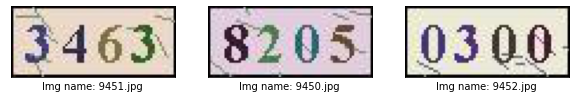

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sample_idxs = np.random.choice(50000, size=25, replace=False)

for img_id, img_name in enumerate(os.listdir(INFER_DATA_PATH)):
    plt.subplot(1, 3, img_id + 1)
    plt.xticks([])
    plt.yticks([])
    im = Image.open(os.path.join(INFER_DATA_PATH, img_name))
    plt.imshow(im, cmap=plt.cm.binary)
    plt.xlabel("Img name: " + img_name)
plt.show()

## 开始预测
> 飞桨2.0 CTC Decoder 相关API正在迁移中，暂时使用[第三方解码器](https://github.com/awni/speech/blob/072bcf9ff510d814fbfcaad43b2883ecf8f60806/speech/models/ctc_decoder.py)进行解码。

In [23]:
from ctc import decode

# 实例化预测模型
model = paddle.Model(Net(is_infer=True), inputs=input_define)
# 加载训练好的参数模型
model.load(CHECKPOINT_PATH)
# 设置运行环境
model.prepare()

# 加载预测Reader
infer_reader = InferReader(INFER_DATA_PATH)
img_names = infer_reader.get_names()
results = model.predict(infer_reader, batch_size=BATCH_SIZE)
index = 0
for result in results[0]:
    for prob in result:
        out, _ = decode(prob, blank=10)
        print(f"文件名：{img_names[index]}，预测结果为：{out}")
        index += 1

Predict begin...
step 1/1 [==============================] - 12ms/step
Predict samples: 3
文件名：9451.jpg，预测结果为：(3, 4, 6, 3)
文件名：9450.jpg，预测结果为：(8, 2, 0, 5)
文件名：9452.jpg，预测结果为：(0, 3, 0, 0)
